In [1]:
# Necessary libraries for our project
import urllib.request
import pandas as pd
import re
import nltk
import math
import networkx as nx
import community
import numpy as np
import os 
import json
import string
import ast
import nltk.stem

from nltk.corpus import PlaintextCorpusReader
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import pos_tag
from matplotlib import pyplot as plt
from imageio import imread
from fa2 import ForceAtlas2
import warnings
warnings.filterwarnings("ignore")

### Click [here](https://socialgraphinhogwarts.boxmode.io/home) go to our website:)

# Table of Content

* [1 Motivation](#motivation)<br>
* [2 Basic Stats](#basic_stats)<br>
    * [2.1 Get Data](#get_data)<br>
        * [2.1.1 Get Character List](#get_character_list)<br>
        * [2.1.2 Get character's wiki page](#get_character_page)<br>
        * [2.1.3 Get Harry Potter books](#get_hp_book)<br>
    * [2.2 Process Data](#process_data)<br>
        * [2.2.1 Extract Characters Appear only in Books](#characters_in_books)<br>
        * [2.2.2 Get the dialogue of each Character](#character_dialogue)<br>
            * [2.2.2.1 Get the dialogue from books](#character_dialogue_book)<br>
            * [2.2.2.2 Get the dialogue from wikipages](#character_dialogue_wiki)<br>
        * [2.2.3 Get the dialogue of each House](#house_dialogue)<br>
            * [2.2.3.1 Get the dialogue of each House from Book](#house_dialogue_book)<br>
            * [2.2.3.2 Get the dialogue of each House from Wiki](#house_dialogue_wiki)<br>
* [3 Tools, Theory and Analysis](#tools_theory_analysis)<br>
    * [3.1 Network](#network)<br>
        * [3.1.1 Generating Network](#generating_network)<br>
        * [3.1.2 Analyzing Networks](#network_statistics)<br>
        * [3.1.3 Friendship Paradox](#friendship_paradox)<br>
        * [3.1.4 Six Degrees of Separation](#small_world)<br>
        * [3.1.5 Visualizations](#visualization)<br>
            * [3.1.5.1 Visualizations for House](#vs_house)<br>
            * [3.1.5.2 Visualizations for Gender](#vs_gender)<br>
            * [3.1.5.3 Visualizations for Blood](#vs_blood)<br>
    * [3.2 Text Analysis](#text_analysis)<br>
        * [3.2.1 WordCloud of Houses and Characters](#wordcloud_house_character)<br>
            * [3.2.1.1 WordCloud of Houses](#wordcloud_house)<br>
            * [3.2.1.2 Wordcloud of Characters](#wordcloud_character)<br>
        * [3.2.2 Sentiment analysis](#sentiment_analysis)<br>
            * [3.2.2.1 Sentiment analysis on characters](#sentiment_character)<br>
            * [3.2.2.2 Sentiment analysis on houses](#sentiment_house)<br>
    * [3.3 Community Detection](#community_detection)<br>
* [4 Discussions](#discussion)<br>
* [5 Contributions](#contribution)<br>

<a id='motivation'></a>
# 1 Motivation

* **Our Dataset:**

>We decide to use [Harry Potter Wiki](https://harrypotter.fandom.com/wiki/Main_Page) as our main data sourse. In this website, we can get the characters of Harry Potter and their information. The document of this API could be found at [here](https://www.mediawiki.org/wiki/API:Main_page), and the sandbox of the API could be found at [here](https://harrypotter.fandom.com/wiki/Special:ApiSandbox). 

* **Why we choose Harry Potter:**

>Harry Potter has hundreds of characters which is a good analysing resource. The plot of the Harry Potter is simple, there are clear good guys and bad guys in HP books. The analysing material we need can be easily acquired from Fandom wiki(character list, character relationship), and websites(text books). Besides, Harry Potter is a classic memory of our three's childhood, we are glad to revisit it:)

* **Our goal for end user:**

>We want to show user how many characters are there in the HP books, who are main characters(3.1.2). After generating the network of Harry Potter, we will paint it according to houses, genders and bloods to show users our insights(3.1.5). We will explore Friendship Paradox(3.1.3) and Six Degrees of Separation(3.1.4) to show user whether HP network follows some rules in real social network. By displaying wordclouds of characters and houses(3.2.1), you will have a general understanding of them. In addition, we will tell you who are the most happiest characters, who are saddest(3.2.2). At last, are you curious about which characters will be assigned in the same community by LA algorithm, answers can be found in Community Detection(3.3)? 


<a id='basic_stats'></a>
# 2 Basic stats
<a id='get_data'></a>
## 2.1 Get Data
In this section, our main job divided into three part.
* Get characters list
* Get character's wiki page
* Get Harry Potter books   

<a id='get_character_list'></a>
### 2.1.1 Get Character List
Inside Fandom, there's no direct character list of the whole Harry Potter stories. Take a look at the webpage of [individuals in Harry Potter](https://harrypotter.fandom.com/wiki/Category:Individuals), you would find out that here contains lots of categories. We deccide to get the Characters List by [gender](https://harrypotter.fandom.com/wiki/Category:Individuals_by_gender).

In [269]:
##because mediawiki API only allowed get 500 pages one time, the API will return left page information
##So there are two types query
def getquery(gender,cmcontinuekey):
    baseurl = "https://harrypotter.fandom.com/api.php?"
    action = "action=query"
    dataformat ="format=json"
    listtype = "list=categorymembers"
    cmtitle = "cmtitle=Category:%s"%gender
    cmlimt = "cmlimit=max"
    if cmcontinuekey!=None:
        cmcontinue = "cmcontinue=%s" % cmcontinuekey
        query= "{}{}&{}&{}&{}&{}&{}".format(baseurl, action, dataformat,listtype,cmtitle,cmlimt,cmcontinue)
    else:
        query= "{}{}&{}&{}&{}&{}".format(baseurl, action, dataformat,listtype,cmtitle,cmlimt)
    return query

In [270]:
##Through query information, we define a function to get wikitext
def getwikitext(query):
    wikiresponse = urllib.request.urlopen(query)
    wikidata= wikiresponse.read()
    wikitext= wikidata.decode('utf-8')
    return wikitext

In [271]:
## The category is divided by gender, through which we can get the titles of all the characters
def getwikipages(genderinput):
    control = True
    query = getquery(gender =genderinput,cmcontinuekey = None)
    wikitext = getwikitext(query)
    wikitext1 = wikitext
    while control == True:
        cmcontinuekey=re.findall(r'\"cmcontinue\"\:\"(.*?)\"',wikitext)
        if len(cmcontinuekey)!=0:
            query = getquery(gender = genderinput,cmcontinuekey=cmcontinuekey[0])
            wikitext = getwikitext(query)
            wikitext1 +=wikitext
        else: 
            control = False
    
    titles=re.findall(r'\"title\"\:\"(.*?)\"',wikitext1)
    return titles

In [274]:
#Get the titles of all the characters
titles_female = getwikipages('Females')
titles_male = getwikipages('Males')
titles_unknown = getwikipages('Individuals_of_unknown_or_undetermined_gender')

In [ ]:
#Data preprocessing
#Some characters name include 'Unidentified', we have no interesting of these characters, so we drop them
for title in titles_female:
    if 'Unidentified' in title:
        titles_female.remove(title)
for title in titles_male:
    if 'Unidentified'in title:
        titles_male.remove(title)
for title in titles_unknown:
    if 'Unidentified' in title:
        titles_unknown.remove(title)

In [275]:
#Get characters list from titles and save them into csv file
titles = titles_female+titles_male+titles_unknown
gender = len(titles_female)*['Female']+len(titles_male)*['Male']+len(titles_unknown)*['Unknown']
characters = pd.concat([pd.DataFrame({"Name":titles}),pd.DataFrame({"Gender":gender})], axis = 1)
characters = characters.drop_duplicates(subset=['Name'], keep=False)

characters.to_csv('HarryPotter_Characters1.csv',encoding='utf-8',index = False)

>When generate the csv file, we found there are some blank row, so we delete them manually. Then we get HarryPotter_Characters.csv.

<a id='get_character_page'></a>
### 2.1.2 Get character's wiki page
The next step is to get their Fandom pages. We still use the API from Fandom to get tha page contents.    
In this part, we plan to get two types of wiki page. The first one contain the links, we will use these links to generate the network. And the other one is readable type, we will use these documents for sentiment analysis.

In [4]:
#Read the characters name from csv file
df = pd.read_csv('HarryPotter_Characters.csv',encoding='utf-8') # read name from csv
df_characters = df['Name'].values.tolist() #all of names

In [277]:
#Download wikipage of all the characters
for character in df_characters:
    name_url= urllib.parse.quote_plus(character) #change all of the pause into '_'
    baseurl = "https://harrypotter.fandom.com/api.php?"
    action = "action=query"
    title = "titles=%s"%(name_url)
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')


    json.loads(wikitext)
    
    with open('./CharactersWiki/%s.txt'%(character), 'w',encoding='utf-8') as outfile:
        json.dump(wikitext, outfile)

In [278]:
#In order to implement sentiment analysis, we also want to get a readable wikipage of each characters
for character in df_characters:
    name_url = urllib.parse.quote_plus(character)
    baseur = "https://harrypotter.fandom.com/api.php?"
    action = "action=query"
    title = "titles=%s" % name_url
    content = "prop=extracts&exlimit=1&explaintext"
    dataformat ="format=json"


    query = "{}{}&{}&{}&{}".format(baseur, action, content, title, dataformat)


    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    path = "CharactersWiki_readable\%s.txt" % character

    a = json.loads(wikitext)
    pages = a['query']['pages'].keys()
    for page in pages:
        b = a['query']['pages'][page]['extract']
    with open(path,'w', encoding='utf-8') as f:
            f.write(b)

<a id='get_hp_book'></a>
### 2.1.3 Get Harry Potter books
We download the seven Harry Potter books from website as our data source for sentiment analysis.

<a id='process_data'></a>
## 2.2 Process data
This section contains 3 part: 
* Get characters which appear in book as well as the attributes we use latter
* Get character's dialogue both from books and wikipage 
* Get House's dialogue both from books and wikipage

<a id='characters_in_books'></a>
### 2.2.1 Extract Characters Appear only in Books
There are more than 3000 characters we extract from Fandom Harry Potter wiki. Since the full characters list includes Fantastic Beasts, HP games, movies and other fan fictions, we decided to filter the characters and only keep the characters appear in HP books. Too many people are not conducive to analysis, especially in network visualization part.

In the mean time, when filtering out the characters, we use regex to **get their attributes of house, gender, blood and links with each other**. We are to lucky since the links in HP pages are all like `[something we need]` or `[something we need|...]`.

In [5]:
# some useful regex:
re_appearances = 'Appearances==.*==Notes and references'
re_book = '\{\{(\w*)\}\}'
re_house = 'house = \[\[(.*?)(?:\|.*?)?\]\]'
re_gender = 'gender = (\w*)'
re_blood = 'blood = \[\[(.*?)(?:\|.*?)?\]\]'
re_link = '\[\[(.*?)(?:\|.*?)?\]\]'

# HP book code in wiki page:
HP_series = ['PS', 'COS', 'POA', 'GOF', 'OOTP', 'HBP', 'DH']

In [6]:
name_valid = [] # contains the name we filter out, now we have 808 people
houses = []; genders = []; bloods = []; links = []

for n in df_characters:
    with open('CharactersWiki\%s.txt'%n, 'r') as f:
        info = f.read()
        try:
            appearance_txt = re.search(re_appearances, info).group()
            books = re.findall(re_book, appearance_txt)
            if bool(set(books) & set(HP_series)): 
                name_valid.append(n)
                house = re.findall(r'%s'%re_house, info); houses.append(house[0]) if house else houses.append('unknown')
                gender = re.findall(r'%s'%re_gender, info); genders.append(gender[0]) if gender else genders.append('unknown')
                blood = re.findall(r'%s'%re_blood, info); bloods.append(blood[0]) if blood else bloods.append('unknown')
                link = re.findall(r'%s'%re_link, info); links.append(link)
        except AttributeError:
            pass

In [8]:
data = {'houses': houses, 'genders': genders, 'bloods': bloods, 'links': links}
df_my = pd.DataFrame(data, index=name_valid) # for graph visualization
df = pd.DataFrame(data, index=name_valid)

# standardize some gender attributes:
df["genders"].replace({"Unknown":"unknown", "":"unknown", 'Females':'Female', 'Males':'Male'}, inplace=True)
# replace some kinds of bloods with only 1 or 2 characters:
df['bloods'].replace({"Giant":"others", "Half-Goblin":"others", 'Half-Veela':'others', 'Half-breed':'others', 
                      'Magic':'others', 'Non-magic people':'Muggle', 'Part-Human':'others', 'Squib':'others'}, inplace=True)

# standardize some gender attributes:
df_my["genders"].replace({"Unknown":"unknown", "":"unknown", 'Females':'Female', 'Males':'Male'}, inplace=True)
# replace some kinds of bloods with only 1 or 2 characters:
df_my['bloods'].replace({"Giant":"others", "Half-Goblin":"others", 'Half-Veela':'others', 'Half-breed':'others', 
                      'Magic':'others', 'Non-magic people':'Muggle', 'Part-Human':'others', 'Squib':'others'}, inplace=True)

df.reset_index(inplace=True); 
df.rename({'index':'Name'}, axis=1, inplace=True)
#df.to_csv('HCharacters_info_808.csv')
# display the characters and their attributes which we will keep using:
df[:5]

Name      houses genders      bloods  \
0           Hannah Abbott  Hufflepuff  Female  Half-blood   
1  Hannah Abbott's mother     unknown  Female     unknown   
2              Aged witch     unknown  Female     unknown   
3                   Agnes     unknown  Female     unknown   
4       Millicent Bagnold   Ravenclaw  Female     unknown   

                                               links  
0  [1 September, 1979, 31 August, 1980, Half-bloo...  
1  [1996, Great Britain, Human, Hannah Abbott, Ne...  
2  [Great Britain, Human, Knockturn Alley, Wizard...  
3  [Agnes Monkleigh, File:Agnes.png, Great Britai...  
4  [1963, Minister for Magic, Human, Minister for...

<a id='character_dialogue'></a>
### 2.2.2 Get the dialogue of each Character
In sentiment analysis, we plan to analysis each character's emotion. In order to do that, we need to generate dialogue for each character based on the book content(2.1.3) and wikipage content(2.1.2)    

Due to at the begining and end of each book, there are many irrelevant content, we delete these manually.
<a id='character_dialogue_book'></a>
#### 2.2.2.1 Get the dialogue from books

In [281]:
#There are seven books in total, we need to combine all the books into one book first.
path = './Book/'
file_list = os.listdir(path)
book = ''
for bookname in file_list:
    with open(path+bookname,"r", encoding='utf-8') as f:
        bookcontent = f.read()
        book += bookcontent
        
path = 'Book.txt'
with open(path,'w', encoding='utf-8') as f:
            f.write(book)

In [282]:
#open Book and spilt sentence
path = 'Book.txt'
with open(path,'r', encoding='utf-8') as f:
            book = f.read()
sentences_book = re.split("(?<=[.!?])\s+", book)

For each character, we will check whether its name appears in the sentence, it true, then we will say this sentence is the character's dialogue. Because most of the characters have family name and first name, take Harry Potter as example, both Harry and Potter will be metioned in the book. So we decide for the top 50 degree characters, we will check both their family name and middle name and last name; for other characters, we will only check their full name. Through this way, we get the dialogues of each character.

In [285]:
characters = df.Name.tolist()
with open('top50character.json','r') as f:  #this file will be generated in 3.1.2
    top50cha = json.load(f)

In [286]:
#Search character name in each sentence
booktext = {}
for character in characters:
        content = []
        if character in top50cha:
            names = character.split(' ')
            for sentence in sentences_book: 
                for name in names:      #case 1:Take Harry Potter as example, most time just Harry or Potter exists in the sentence
                    if name in sentence:
                        content.append(sentence)
        else:
            for sentence in sentences_book:
                if character in sentence:
                        content.append(sentence)

        if len(content) != 0:    
            booktext[character] = content

In [287]:
with open('./booktext.json','w') as f:
    json.dump(booktext,f)

>We found not all the characters have diglogue based on the books content, so we generate a new list of characters which have dialogue. There are 418 characters have dialogue based on the book.

In [297]:
bookname = list(booktext.keys())
#df = pd.read_csv('HCharacters_info_808.csv')
for name in bookname:
    if name in characters:
        characters.remove(name)
for name in characters:
    df_dropped = df.drop(df[df['Name']==name].index)
df_dropped.to_csv('CharactersInBook.csv',encoding='utf-8')

<a id='character_dialogue_wiki'></a>
#### 2.2.2.2 Get the dialogue from wikipages

In [289]:
path = './CharactersWiki_readable/'
wikitext = {}
for character in characters:
        with open(path+character+'.txt','r',encoding='utf-8') as f:
            wikicontent = f.read()
        wikisentence = re.split("(?<=[.!?])\s+", wikicontent)
        wikitext[character] = wikisentence

In [290]:
with open('./wikitext.json','w') as f:
    json.dump(wikitext,f)

<a id='house_dialogue'></a>
### 2.2.3 Get the dialogue of each House
<a id='house_dialogue_book'></a>
#### 2.2.3.1 Get the dialogue of each House from Book

In [301]:
df_characters_inBook = pd.read_csv('CharactersInBook.csv')
names = df_characters_inBook['Name'].values.tolist() #Get the characters name list
houses = df_characters_inBook['houses'].values.tolist() #Get the houses list
houses = list(set(houses)) #Get the unique house name 
#Get the index of each house's character

houses_index = []
for house in houses:
    index = df_characters_inBook[df_characters_inBook.houses==house].index.tolist() 
    houses_index.append(index)
    
#Get the house text from wikipage
path = './CharactersWiki_readable/'
housebook={}
for i in range(len(houses)):
    housestext = ''
    for index in houses_index[i]:
        name = names[index] + '.txt'
        with open(path+name,'r', encoding='utf-8') as f:
            content = f.read() 
        housestext += content+'\s'
    sentences_housetext = re.split("(?<=[.!?])\s+", housestext)
    housebook[houses[i]] = sentences_housetext
    
with open('./housebook.json','w') as f:
    json.dump(housebook,f)

<a id='house_dialogue_wiki'></a>
#### 2.2.3.2 Get the dialogue of each House from Wiki

In [70]:
#df_characters = pd.read_csv('HCharacters_info_808.csv')
names = df['Name'].values.tolist() #Get the characters name list
houses = df['houses'].values.tolist() #Get the houses list
houses = list(set(houses)) #Get the unique house name 

#Get the index of each house's character
houses_index = []
for house in houses:
    index = df[df.houses==house].index.tolist() 
    houses_index.append(index)

#Get the house text from wikipage
path = './CharactersWiki_readable/'
housewiki={}
for i in range(len(houses)):
    housestext = ''
    for index in houses_index[i]:
        name = names[index] + '.txt'
        with open(path+name,'r', encoding='utf-8') as f:
            content = f.read() 
        housestext += content+'\s'
    sentences_housetext = re.split("(?<=[.!?])\s+", housestext)
    housewiki[houses[i]] = sentences_housetext

with open('./housewiki.json','w') as f:
    json.dump(housewiki,f)

<a id='tools_theory_analysis'></a>
# 3 Tools, Theory and Analysis
<a id='network'></a>
## 3.1 Network
This section mainly contains 3 parts: 
* Building Network and demonstrate the characteristics of the network
* Verify friendship paradox and six degrees of seperation
* Visualize network

<a id='generating_network'></a>
### 3.1.1 Generating Network
First of all, we built a network for this magical world. The **nodes** of our network correspond to the characters. The **edge** between the nodes is added if there is a hyperlink in a character's page that link to another node of the network (e.g. another character).

In [9]:
# build network, first is directed graph:
G_di = nx.DiGraph()

# add nodes:
for name in name_valid:
    info = df_my.loc[name]
    G_di.add_node(name, house=info.houses, gender=info.genders, blood=info.bloods)
# add edges:
for name in name_valid:
    links = df_my.loc[name].links
    for l in links:
        if l in name_valid: G_di.add_edge(name, l)

# Ready a non-directed graph for latter use.
G = G_di.to_undirected(as_view=True)

# Ready GCC for later use:
lc = sorted(nx.connected_components(G), key=len, reverse=True)
GCC = G.subgraph(lc[0])

In [10]:
# Statistics about our graph:

print('Number of nodes: %d'%G.number_of_nodes())
print('Number of edges: %d'%G.number_of_edges())

Number of nodes: 807
Number of edges: 8585


<a id='network_statistics'></a>
### 3.1.2 Analyzing Networks
First, we plot the in and out degree distribution of our network. Then we plot a log-log in and out degree distribution.

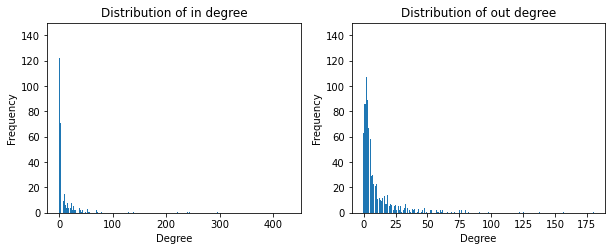

In [236]:
# show degree distribution for directed graph:
in_d, in_c = np.unique(list(dict(G_di.in_degree()).values()), return_counts=True)
out_d, out_c = np.unique(list(dict(G_di.out_degree()).values()), return_counts=True)

plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
plt.bar(in_d, in_c)
plt.title('Distribution of in degree'); plt.xlabel("Degree"); plt.ylabel("Frequency"); plt.ylim(0, 150)
plt.subplot(1,2,2)
plt.bar(out_d, out_c)
plt.title('Distribution of out degree'); plt.xlabel("Degree"); plt.ylabel("Frequency"); plt.ylim(0, 150)
plt.savefig('./Figures/degree_distribution.png',dpi = 200)
plt.show()

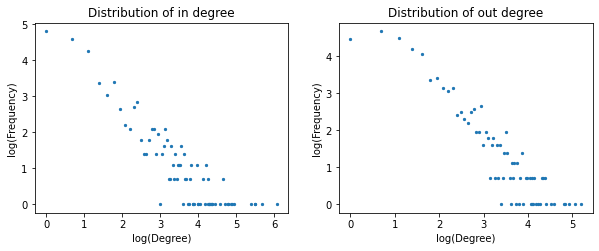

In [237]:
# then we plot a log-log plot to confirm the degree distribution follows the power-low:
plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
plt.scatter(np.log(in_d), np.log(in_c), s=5)
#plt.yscale('log'); plt.xscale('log')
plt.title('Distribution of in degree'); plt.xlabel("log(Degree)"); plt.ylabel("log(Frequency)")
plt.subplot(1,2,2)
plt.scatter(np.log(out_d), np.log(out_c), s=5)
plt.title('Distribution of out degree'); plt.xlabel("log(Degree)"); plt.ylabel("log(Frequency)")
_ = plt.savefig('./Figures/degree_distribution_log.png',dpi = 200)

>Criteria of **power-low**: $logp_{k}\sim -\gamma logk$. $k$ is degree, $p_{k}$ is the probability that a randomly chosen node has $k$ degree.
From the plots, we know that the network generally follows the **power-low**. Because we observe the log-log plot, the slope approximates a constant.

In [232]:
# Save a copy of top-50 degree characters:
top50_degree = sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)[:50]
characters_50 = []
for character, degree_centrality_score in top50_degree:
    characters_50.append(character)
with open('top50character.json', 'w') as f:
    json.dump(characters_50, f)

**Degree Centrality**

Degree centrality are calculated based on the degree of a node (e.g. the number of one-hop nodes link to the node). The higher degree centrality, the more connected. Below is the top-10 most connected characters:

In [145]:
degree_centrality = {k: v for k, v in sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)[:10]}
print('Top-10 most connected characters:\n')
for i, (character, degree_centrality_score) in enumerate(degree_centrality.items()):
    i += 1
    print('No.%d  %s: %f'%(i, character, degree_centrality_score))

Top-10 most connected characters:

No.1  Harry Potter: 0.756824
No.2  Tom Riddle: 0.518610
No.3  Ronald Weasley: 0.473945
No.4  Albus Dumbledore: 0.468983
No.5  Hermione Granger: 0.452854
No.6  Severus Snape: 0.285360
No.7  Rubeus Hagrid: 0.260546
No.8  Sirius Black: 0.254342
No.9  Ginevra Weasley: 0.253102
No.10  Dolores Umbridge: 0.249380


**Betweenness Centrality**

Betweenness centrality is calculated by identifying all the shortest paths and then counting how many times each node participate in the shortest paths. Higher betweenness centrality means it is more likely for a node to connect other nodes. 

In [146]:
# Betweenness centrality:
betweenness_centrality = {k: v for k, v in sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse=True)[:10]}
print('Top-10 most betweenness-central nodes:\n')
for i, (character, between_centrality_score) in enumerate(betweenness_centrality.items()):
    i += 1
    print('No.%d  %s: %f'%(i, character, between_centrality_score))

Top-10 most betweenness-central nodes:

No.1  Harry Potter: 0.301033
No.2  Tom Riddle: 0.110678
No.3  Ronald Weasley: 0.079695
No.4  Albus Dumbledore: 0.075507
No.5  Hermione Granger: 0.070803
No.6  Arthur Weasley: 0.028777
No.7  Rubeus Hagrid: 0.028378
No.8  Severus Snape: 0.018660
No.9  Sirius Black: 0.017728
No.10  Dolores Umbridge: 0.014270


**Eigenvector Centrality**

Eigenvector centrality is calculated by considering the connection of a node in the whole network. Namely it will count the degree of a node and the degree of nodes connected to that node and so on. The higher eigenvector centrality, the more influence of the node on the network.

In [147]:
# Eigenvector centrality:
eigenvector_centrality = {k: v for k, v in sorted(nx.eigenvector_centrality(G).items(), key=lambda item: item[1], reverse=True)[:10]}
print('Top-10 most eigenvector-central nodes:\n')
for i, (character, eigenvector_centrality_score) in enumerate(eigenvector_centrality.items()):
    i += 1
    print('No.%d  %s: %f'%(i, character, eigenvector_centrality_score))

Top-10 most eigenvector-central nodes:

No.1  Harry Potter: 0.231603
No.2  Tom Riddle: 0.204526
No.3  Ronald Weasley: 0.197732
No.4  Hermione Granger: 0.192464
No.5  Albus Dumbledore: 0.186123
No.6  Severus Snape: 0.156940
No.7  Draco Malfoy: 0.144244
No.8  Ginevra Weasley: 0.140880
No.9  Sirius Black: 0.139447
No.10  Dolores Umbridge: 0.136906


In [148]:
# use a table to gather the results:
centrality_data = {'Degree Centrality': list(degree_centrality.keys()), 'Betweenness Centrality': list(betweenness_centrality.keys()), 
                   'Eigenvector Centrality': list(eigenvector_centrality.keys())}
pd.DataFrame(centrality_data)

Degree Centrality Betweenness Centrality Eigenvector Centrality
0      Harry Potter           Harry Potter           Harry Potter
1        Tom Riddle             Tom Riddle             Tom Riddle
2    Ronald Weasley         Ronald Weasley         Ronald Weasley
3  Albus Dumbledore       Albus Dumbledore       Hermione Granger
4  Hermione Granger       Hermione Granger       Albus Dumbledore
5     Severus Snape         Arthur Weasley          Severus Snape
6     Rubeus Hagrid          Rubeus Hagrid           Draco Malfoy
7      Sirius Black          Severus Snape        Ginevra Weasley
8   Ginevra Weasley           Sirius Black           Sirius Black
9  Dolores Umbridge       Dolores Umbridge       Dolores Umbridge

>From the above 3 kinds of centrality, we can see the top-5 most important characters are **always Harry, You-Know-Who, Ron, Hermione and Dumbledore**, which I think are within our expection. In degree centrality, the top-6 to top-10 are Severus Snape, Rubeus Hagrid, Sirius Black, Ginevra Weasley and Dolores Umbridge. In betweenness centrality, the top-6 to top-10 are Arthur Weasley, Rubeus Hagrid, Severus Snape, Sirius Black, and Dolores Umbridge. In eigenvector centrality, the top-6 to top-10 are Severus Snape, Draco Malfoy, Ginevra Weasley, Sirius Black, and Dolores Umbridge. To our surprise, we see **Arthur Weasley** is in No.6 of betweenness centrality. Given Arthur Weasley is a core member in Order of the Phoenix and Weasley's are always Harry's firm supporters, we think it's also reasonable. We are surprise to see **Dolores Umbridge** in every kind of centralities. We think that's because even though Umbridge starts to appeared in the Order of Phoenix, she plays a very important role in the Order of Phoenix and the following books.

<a id='friendship_paradox'></a>
### 3.1.3 Friendship Paradox
In this part, we verify the interesting friendship paradox. The friendship paradox states that almost everyone has fewer friends than their friends have on average. It is because we live in a social network with a power-law degree distribution where almost everyone's friends has a hub, that drives up the average degree of the friends.

In [156]:
# verify friendship paradox:
true_counter = 0
for n in name_valid:
    degree = G.degree[n]
    adjs =list(G.neighbors(n))
    adjs_degree = [G.degree[i] for i in adjs]
    if np.mean(adjs_degree) > degree: true_counter += 1

print('The correct rate of friendship paradox in HP is : ', true_counter/len(name_valid))

The correct rate of friendship paradox in HP is :  0.8748451053283767


>For one node, we find out all of its neighbors, calculating the average degree of its neighbors, then compare that with the node's degree. We do the same thing for all nodes, counting the true condition (e.g. average degree of neighbors $>$ node's degree). At last, we will get a rate of nodes that follow the friendship paradox in HP network, which is **0.875**. Friendship paradox is valid in our network.

<a id='small_world'></a>
### 3.1.4 Six Degrees of Separation
Six degrees of separation is another interesting theory mentioned in our course. Six degrees of separation is the idea that all people are six or fewer social connections away from each other. As a result, a chain of "friend of a friend" statements can be made to connect any two people in a maximum of six steps. It is also known as the **six handshakes rule**. 

In [250]:
# Verify small-world:
def small_world(character):
    """
    Input: any character name, we choose 'Dobby' and 'Luna Lovegood' in this example
    OutPut: a barchart shows a gradual cover rate step by step.
    """
    steps = nx.single_source_shortest_path_length(GCC, character) # GCC:742

    step_rate_add = 0; step_rates = []; step_NArates = []
    for i in range(1,7):    
        steps_i = [n for n in steps if steps[n]==i]
        step_rate = len(steps_i) / len(GCC)
        step_rate_add += step_rate
        step_rates.append(step_rate_add); step_NArates.append(1-step_rate_add)

    df_rate = pd.DataFrame({'Cover Rate':step_rates, 'Not Cover Rate':step_NArates}, index=['step 1', 'step 2', 'step 3', 'step 4', 'step 5', 'step 6'])
    
    df_rate.plot(kind='bar', 
                stacked=True, 
                figsize=(8, 3.5))
    plt.xlabel('Steps from %s'%character); plt.ylabel('Cover rate of HP-GCC')
    plt.xticks(rotation=0); plt.title('Cover rate step by step')
    plt.savefig('./Figures/%s.png'%character,dpi = 200)
    plt.show()

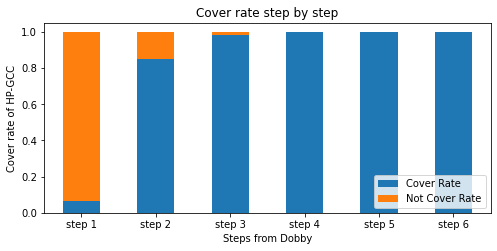

In [251]:
small_world('Dobby')

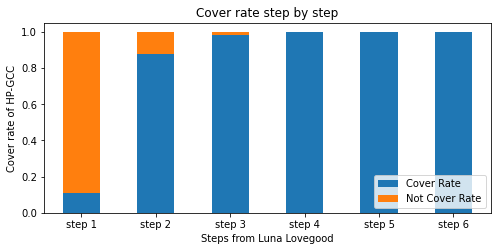

In [252]:
small_world('Luna Lovegood')

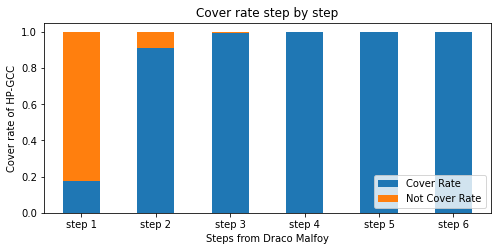

In [253]:
small_world('Draco Malfoy')

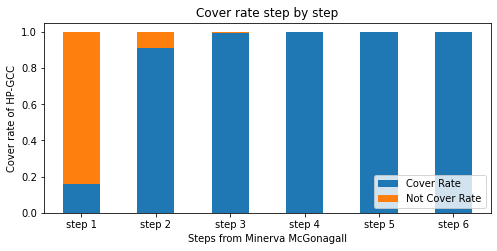

In [254]:
small_world('Minerva McGonagall')

We further verify the Six Degrees of Separation by calculating the average shortest path for all node in our network:

In [154]:
# average shortest path:
nx.average_shortest_path_length(GCC)

2.526220957799905

>Our function `small_world(character)` visually show starts from a node in the network, all other nodes are at most 6 steps (3 steps in our network actually) away from it, here we show that for Dobby and Luna Lovegood as 2 examples. We randomly choose many other characters to display the results, they all fully cover the network within 4 steps. In addition, the average shortest path of our network is **2.53**. Those are side verifications of six degrees of separation.

<a id='visualization'></a>
### 3.1.5 Visualizations
In the network visualization section, we will create bar charts to show the distribution of houses, genders and bloods.
Then we visualize the GCC of our network and color the node according to houses(Gryffindor, Hufflepuff, Ravenclaw, Slytherin, unknown), genders(Male, Female, unknown) and bloods(Pure-blood, Half-blood, Muggle-born, Muggle, unknown). 
In addition, we set the **node size** of each node equals to node degree $\times$ 10.

In [16]:
'''
Generating positions for force atlas, all of our graph visualization will use the same position
which is convenient to compare.
'''
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.94it/s]

BarnesHut Approximation  took  3.20  seconds
Repulsion forces  took  26.95  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.17  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


<a id='vs_house'></a>
#### 3.1.5.1 Houses
As we know, there are 4 houses in Hogwarts, they are Gryffindor, Hufflepuff, Ravenclaw, and Slytherin. 'House' is an attribute of the nodes, which will be used to decide the node color. For those without house information, we assign 'unknown' to them and paint them grey.

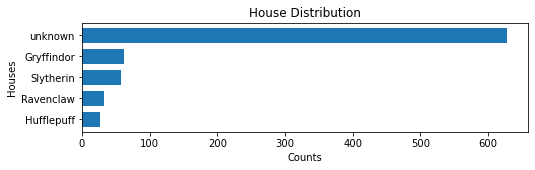

In [262]:
plt.figure(figsize=(8,2))
house_count = df_my['houses'].value_counts(ascending=True)
plt.barh(house_count.index, house_count, height=0.7)
plt.xlabel('Counts'); plt.ylabel('Houses'); _ = plt.title('House Distribution')

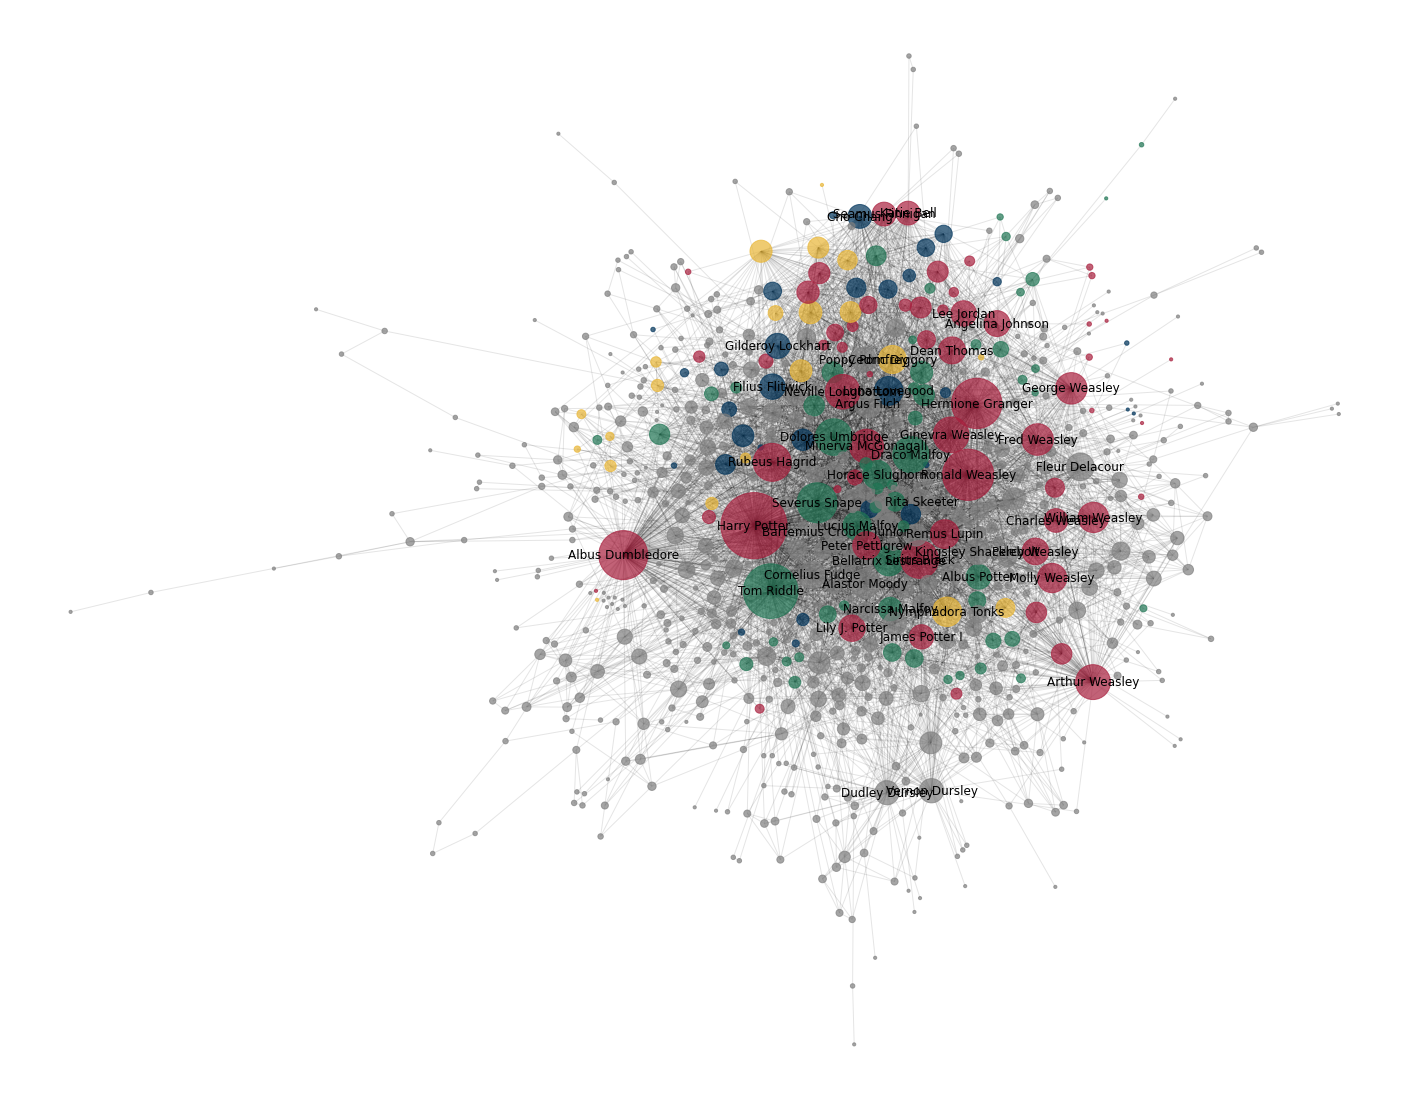

In [25]:
node_size = [i*10 for i in dict(GCC.degree).values()]
node_color=[];  houses = list(nx.get_node_attributes(GCC, 'house').values())
for h in houses:
    if h == 'Gryffindor':
        node_color.append("#A9203E") # red
    elif h == 'Hufflepuff':
        node_color.append('#E9B636') # yellow
    elif h == 'Ravenclaw':
        node_color.append('#00345B') # blue
    elif h == 'Slytherin':
        node_color.append('#217655') # green
    else:
        node_color.append('#808080') # grey

plt.figure(figsize=(25, 20))
nx.draw_networkx_nodes(GCC, positions, node_size=node_size, node_color=node_color, alpha=0.7)
nx.draw_networkx_edges(GCC, positions, alpha=0.1)

labels_temp = [k for k, v in sorted(dict(GCC.degree).items(), key=lambda item: item[1], reverse=True)[:50]]
labels = {}
for node in labels_temp:
    labels[node] = node
nx.draw_networkx_labels(GCC,positions,labels,font_size=12, font_color='k')

plt.axis('off')
plt.savefig('./Figures/house.png', dpi = 500)
plt.show()

> * From the above both bar chart and forced-directed network, we observe that the people have no house attribute are far more than those with the house attribute. Gryffindor and Slytherin have more students mentioned in the books than the other 2 houses.
> * From the forced-directed network, we can see that the degree of the grey nodes (no house attribute) is lower than the nodes of 4 houses. Gryffindor and Slytherin nodes have a relatively higher degree than all other nodes, considering the top-10 in 3 kinds of centrality are all Gryffindor and Slytherin people, we think it’s reasonable.

<a id='vs_gender'></a>
#### 3.1.5.2 Gender
In this part, we paint male characters blue, and paint female characters pink. For those without gender information, we paint the nodes grey.

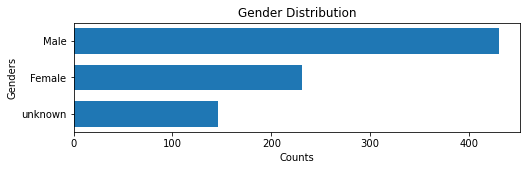

In [164]:
# Gender distribution
plt.figure(figsize=(8,2))
gender_count = df['genders'].value_counts(ascending=True)
plt.barh(gender_count.index, gender_count, height=0.7)
plt.xlabel('Counts'); plt.ylabel('Genders'); _ = plt.title('Gender Distribution')

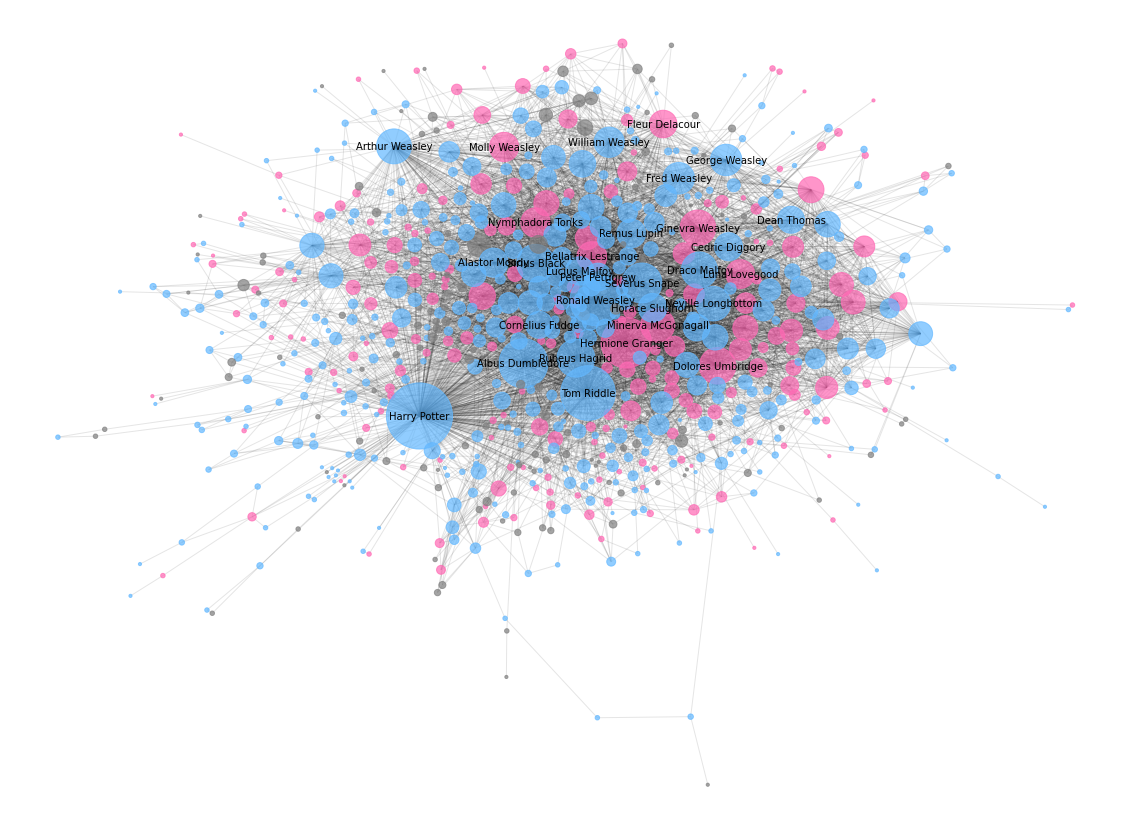

In [263]:
# visualize network based on gender:
node_color=[];  genders = list(nx.get_node_attributes(GCC, 'gender').values())
for g in genders:
    if g == 'Female':
        node_color.append("#FF69B4") # pink
    elif g == 'Male':
        node_color.append('#63B8FF') # blue
    else:
        node_color.append('#808080') # grey 

plt.figure(figsize=(20, 15))
nx.draw_networkx_nodes(GCC, positions, node_size=node_size, node_color=node_color, alpha=0.7)
nx.draw_networkx_edges(GCC, positions, alpha=0.1)
nx.draw_networkx_labels(GCC,positions,labels,font_size=10, font_color='k')
plt.axis('off')
plt.savefig('./Figures/gender.png', dpi = 500)
plt.show()

> * Our purpose to color the nodes according to genders is to check whether girls have more connection with girls, and boys have more connection with boys. From our force-directed graph, we can tell that there is no very clear tendency to make friends based on gender.
> * From both graphs we know the number of male characters are far more than the number of female character. From force-directed graph, the degree of male characters are generally higher than female characters.

<a id='vs_blood'></a>
#### 3.1.5.3 Bloods
There are mainly these kinds of blood in HP books: pure-blood(purple), half-blood(rose red), muggle-born(blue-green), muggle(orange), unknown+others(grey). Others are those bloods with only a few charaters or only one character, like Hagrid and Fleur.

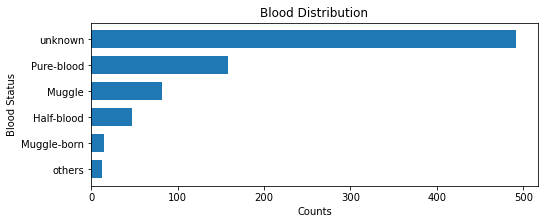

In [168]:
# Blood distribution:
plt.figure(figsize=(8,3))
blood_count = df['bloods'].value_counts(ascending=True)
plt.barh(blood_count.index, blood_count, height=0.7)
plt.xlabel('Counts'); plt.ylabel('Blood Status');  _ = plt.title('Blood Distribution')

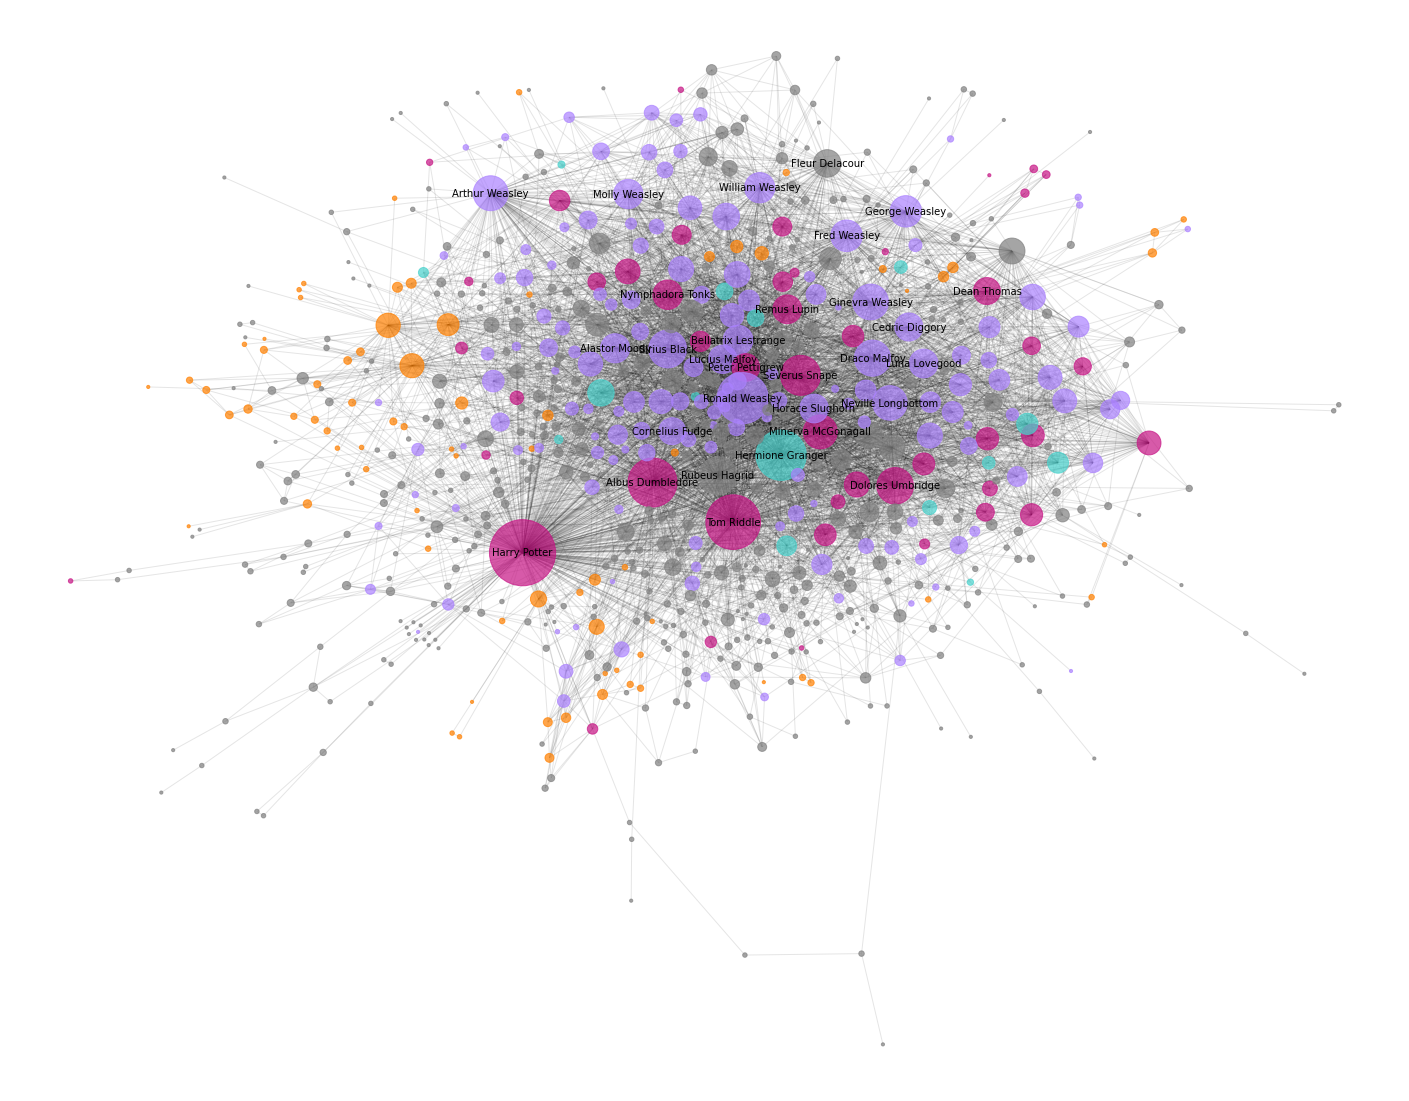

In [267]:
node_size = [i*10 for i in dict(GCC.degree).values()]
node_color=[];  bloods = list(nx.get_node_attributes(GCC, 'blood').values())
for b in bloods:
    if b == 'Pure-blood':
        node_color.append("#AB82FF") # purple
    elif b == 'Half-blood':
        node_color.append('#C71585') # red-pink
    elif b == 'Muggle-born':
        node_color.append('#48D1CC') # blue-green
    elif b == 'Muggle':
        node_color.append('#FF8000') # orange
    else:
        node_color.append('#808080') # grey: others + unknown

plt.figure(figsize=(25, 20))
nx.draw_networkx_nodes(GCC, positions, node_size=node_size, node_color=node_color, alpha=0.7)
nx.draw_networkx_edges(GCC, positions, alpha=0.1)
nx.draw_networkx_labels(GCC,positions,labels,font_size=10, font_color='k')
plt.axis('off')
plt.savefig('./Figures/blood.png', dpi = 500)
plt.show()

> * Apart from the grey nodes, we can see that the pure-blood wizards account for the largest number, while muggle-born wizards account for the least number. The number of muggles is second only to pure-blood wizards, but their degree is generally smaller than all kinds of wizards.
> * The degree of half-blood wizards are relatively higher than other kinds, after all our main characters Harry, Voldemort, Dumbledore... are half-blood wizards. Not surprisingly, the biggest pure-blood node is Ron and the biggest muggle-born node is Hermione.

<a id='text_analysis'></a>
## 3.2 Text analysis
In this section mainly contains two parts:
* WordCloud
* Sentiment analysis    

<a id='wordcloud_house_character'></a>
### 3.2.1 WordCloud of Houses and Characters

<a id='wordcloud_house'></a>
#### 3.2.1.1 WordCloud of Houses
Hogwarts is divided into four houses, Gryffindor, Hufflepuff, Ravenclaw and Slytherin, every year there is a sorting ceremony for new students. The Sorting Hat will assigns corrspongding House based on the student's characteristic. We are wondering what's the most representative words for each house, so we extract the keywords of each house through NLP analysis of wikipages.   

First, we try to use TF-IDF to find the key words.

In [169]:
names = df['Name'].values.tolist() #Get the characters name list
houses = df['houses'].values.tolist() #Get the houses list
houses = list(set(houses)) #Get the unique house name 

In [170]:
houses

['Gryffindor', 'unknown', 'Ravenclaw', 'Slytherin', 'Hufflepuff']

In [171]:
#Get the index of each house's character
houses_index = []
for house in houses:
    index = df[df.houses==house].index.tolist() 
    houses_index.append(index)
#Get the name of each race's character based on index
housesnamelist = []
for i in range(len(houses)):
    housesnamelist.append([])
    for index in houses_index[i]:
        name = names[index] + '.txt'
        housesnamelist[i].append(name)
#get a list of character name for later filter
name_set = []
for name in names:
    name_set.extend(name.lower().split(' '))
name_set = set(name_set)

In [172]:
# define the funtion to process the wikipage text for NLT analysis
stop_words = set(stopwords.words('english'))

def get_word_list(wiki_text):
    token = word_tokenize(wiki_text)
    token_p= [w for w in token if w.isalpha()]#remove the punctuation
    token_p_l = [w.lower() for w in token_p]# lower the words
    token_p_l = [w for (w,pos) in pos_tag(token_p_l) if pos == 'JJ']# take the adjectives words only
    token_p_l_s = [w for w in token_p_l if  w not in stop_words]# remove all the stopwords in English
    # remove the character name  
    token_p_l_s_n = [w for w in token_p_l_s if w not in name_set]
    return token_p_l_s_n

In [173]:
#Build the corpus based on the name list
data_root = './CharactersWiki_readable//'
tf_lists = {}
for i in range(len(houses)):
    house_text = []
    for name in housesnamelist[i]:
        with open(data_root+name,'r', encoding='utf-8') as f:
            name_description = f.read()
            text_processed = get_word_list(name_description)
            house_text.extend(text_processed)
    print('the number of words in {} house: {}'.format(houses[i],len(house_text)))
    tf_house = nltk.FreqDist(house_text)
    tf_lists[houses[i]] = tf_house

the number of words in Gryffindor house: 19864
the number of words in unknown house: 21548
the number of words in Ravenclaw house: 4262
the number of words in Slytherin house: 10515
the number of words in Hufflepuff house: 3444


In [174]:
#Calculate everyword's IDF
everyword = set()
for house in houses:
    everyword = everyword.union(set(tf_lists[house].keys()))
    
everyword_idf = dict()
for word in everyword:
    count = 0
    for house in houses:
        if word in tf_lists[house].keys():
            count = count +1
    everyword_idf[word]=math.log(len(house)/count)

In [175]:
#Calculate tf_idf for every house
tf_idf_list = {}
for i,house in enumerate(houses):
    tf_idf_list[house] = {}
    fdist_temp = tf_lists[houses[i]]
    for word in set(tf_lists[houses[i]].keys()):
        tf_idf_temp = fdist_temp[word]*everyword_idf[word]
        tf_idf_list[house][word] = tf_idf_temp

In [176]:
for house in tf_idf_list.keys():
    tf_idf_h = tf_idf_list[house]
    tf_idf_h_sorted = sorted(tf_idf_h.items(), key=lambda kv: kv[1],reverse=True)
    print('In House {}, the top 10 words according to TF-IDF are:'.format(house))
    for i,each in enumerate(list(tf_idf_h_sorted)[:10]):
        print('({}){}:{:.2f}, '.format(i+1,each[0],each[1]),end='')
    print('\n')

In House Gryffindor, the top 10 words according to TF-IDF are:
(1)able:264.09, (2)many:261.32, (3)due:227.35, (4)good:215.57, (5)dark:198.93, (6)deathly:189.23, (7)great:181.60, (8)new:154.57, (9)final:146.25, (10)ginny:145.56, 

In House unknown, the top 10 words according to TF-IDF are:
(1)deathly:336.18, (2)dark:264.78, (3)unknown:256.46, (4)due:231.51, (5)many:212.80, (6)able:208.64, (7)possible:200.32, (8)early:188.54, (9)likely:187.15, (10)great:180.22, 

In House Ravenclaw, the top 10 words according to TF-IDF are:
(1)many:62.38, (2)dark:54.76, (3)deathly:51.29, (4)due:46.44, (5)great:43.67, (6)able:42.98, (7)good:38.12, (8)unknown:34.66, (9)possible:34.66, (10)true:33.27, 

In House Slytherin, the top 10 words according to TF-IDF are:
(1)dark:180.22, (2)able:149.03, (3)many:144.87, (4)due:131.70, (5)likely:102.59, (6)deathly:99.81, (7)unknown:99.12, (8)great:91.50, (9)possible:85.26, (10)powerful:83.87, 

In House Hufflepuff, the top 10 words according to TF-IDF are:
(1)newt:79

>The result of TF-IDF is showing is above. We print the top 10 words according to TF-IDF， but the result is inconsistent with our expectations, the keys words of each house is similar, which can't show the unique characteristic of each House. We think that's because we only have five documents, use IDF as the weight of each word is not so much useful.
>
>We refer to lecture 7 of last year, in which inroduced a way called TF-TR, may suitable for small sample.  
In general, for some token $t$ belong to document A with term frequency $TF_{self}$ , we define the weight as:
$$
TR = \frac{TF_{self}}{TF_{others} +c}
$$
>$TF_{others}$ is sum term frequency of token in other document, constant $c$ to the denominator in case a word occurs zero times. Then we can get the TF-TR list.

In [177]:
# TF is same as we used in TF-IDF, so we only calculate TR and then we could get the TR for each house
c = 1
tf_tr = {}
for house in tf_lists.keys():
    tf_tr[house] = {}
    other_house = [h for h in tf_lists.keys() if h is not house]
    
    for word in tf_lists[house].keys():
        tf_self = tf_lists[house][word]
        tf_other = []
        for other_h in other_house:
            if word in tf_lists[other_h].keys():
                tf_other.append(tf_lists[other_h][word])
            else:
                tf_other.append(0)
        
        tf_other_sum = np.sum(tf_other)
        w = tf_self/(tf_other_sum + c)
        tf_tr_w= w*(tf_self**(1/2))
        tf_tr[house][word] = tf_tr_w

In [178]:
for house in tf_tr.keys():
    tf_tr_h = tf_tr[house]
    tf_tr_h_sorted = sorted(tf_tr_h.items(), key=lambda kv: kv[1],reverse=True)
    print('In House {}, the top 10 words according to TF-TR are:'.format(house))
    for i,each in enumerate(list(tf_tr_h_sorted)[:10]):
        print('({}){}:{:.2f}, '.format(i+1,each[0],each[1]),end='')
    print('\n')

In House Gryffindor, the top 10 words according to TF-TR are:
(1)sleekeazy:27.00, (2)animagi:27.00, (3)ginny:22.54, (4)dougal:18.52, (5)wormtail:18.52, (6)cleansweep:18.52, (7)good:15.63, (8)animagus:15.49, (9)competitive:14.70, (10)third:13.27, 

In House unknown, the top 10 words according to TF-TR are:
(1)bulgarian:27.94, (2)polish:27.00, (3)slavic:27.00, (4)diet:22.63, (5)deathly:20.15, (6)missionary:18.52, (7)abernathy:18.52, (8)generic:17.46, (9)imperius:17.30, (10)early:16.86, 

In House Ravenclaw, the top 10 words according to TF-TR are:
(1)verdimillious:18.52, (2)dirigible:14.70, (3)fraudulent:8.00, (4)sabbatical:8.00, (5)lorcan:7.54, (6)jewish:5.59, (7)beliefs:5.20, (8)brisk:5.20, (9)honorary:5.20, (10)transmogrifian:5.20, 

In House Slytherin, the top 10 words according to TF-TR are:
(1)bloodline:14.70, (2)mal:11.18, (3)favoured:8.00, (4)pallid:8.00, (5)idiotic:8.00, (6)thuggish:8.00, (7)pathological:8.00, (8)respectable:7.91, (9)delphi:7.54, (10)illegitimate:7.35, 

In Hous

In [179]:
#convert wiki text to str, in order to generate wordcloud.
def tf_tr_to_string(tf_tr_dict):
    word_list = []
    for w in tf_tr_dict:
        tf_tr_value  = tf_tr_dict[w]
        times = math.ceil(tf_tr_value)
        word_list.extend([w]*times)
    string = ' '.join(word_list)
    return string

In [182]:
def draw_wordcloud(community_name,cm):
    tf_tr_list = tf_tr[community_name]
    commu_str = tf_tr_to_string(tf_tr_list)

    wordcloud = WordCloud(
        max_words= 200,
        background_color = 'white',
                          width=800,
                          height=600,
                          collocations=False,
                          colormap= cm
                         ).generate(commu_str)
    path = './Figures/WordCloudHouse/%s.png'%community_name
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('world could for community {}'.format(community_name))
    #plt.savefig(path, dpi = 300)
    plt.show()

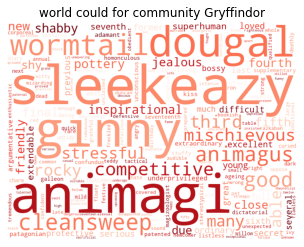

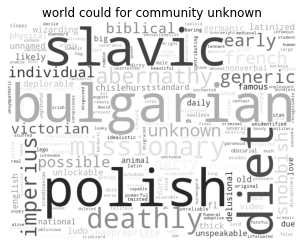

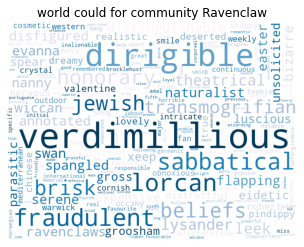

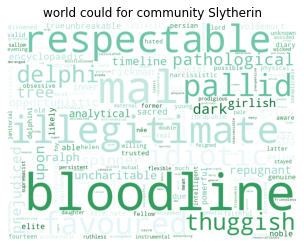

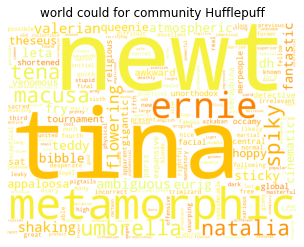

In [183]:
colormap={'Ravenclaw':'PuBu','unknown':'gist_gray','Slytherin':'BuGn','Hufflepuff':'Wistia','Gryffindor':'Reds'}
for i,community in enumerate(tf_tr):
    draw_wordcloud(community,colormap[community])

>Let's see the key words from the wordcloud.    
>**Gryffindor:** Gryffindor values courage, bravery, nerve, and chivalry. From the worcloud, we can find some words such as competitive, good and fridenly, these words correspond with the Gryffindor's values. Besides, we also see some familiar name, such as ginny, wormtail. eventhough we have already filter the character's name when we generate the wordcloud, but we only filter by their full name, rather than nick name. Ginny and wormtail are also important person in Gryffindor, so it’s not werid to see their names in the word cloud.    
>**Slytherins:** The Sorting Hat claims that blood purity is a factor in selecting Slytherins, that Muggle-born students are not sorted there, merely that pure-blooded students are more desirable to that house. From the wordcloud, we can see the most significant word is **bloodline**, which is reasonable.    
>**Hufflepuff:** Hufflepuff values hard work, patience, justice, and loyalty. According to Rowling, Hufflepuff corresponds roughly to the element of earth. Unlucky we can't find such word in the wordcloud. On the contrary, we found some interesting names: tina,newt etc. They belongs to Fantastic Beasts and Where to Find Them and also appeared in Harry Potter series. Newt is a famous student of Hufflepuff, that's why his name appears in the Hufflepuff wordcloud.    
>**Ravenclaw:** Ravenclaw values intelligence, learning, wisdom and wit. The house mascot is an eagle and the house colours are blue and bronze. Key words such as beliefs, honorary meet their qualities. It's very funny that some key words are charm, such as verdimillious and transmogrifian. Maybe because the students of Ravenclaw always talk about study~

<a id='wordcloud_character'></a>
#### 3.2.1.2 Wordcloud of characters
Just for fun, we also generate some wordcloud for the characters we interested.

In [184]:
namelist = ['Albus Dumbledore','Dobby','Dolores Umbridge','Draco Malfoy','Harry Potter','Hermione Granger','Ronald Weasley','Rubeus Hagrid','Severus Snape','Tom Riddle']
with open('./booktext.json','r',encoding='utf-8') as f:
    booktext = json.load(f)

In [190]:
def generate_wordcloud(charactername):
#    with open('./BookText/'+charactername+'.txt','r',encoding='utf-8') as f:
#        character_book = f.read()
    character_book = booktext[charactername]
    character_book = ' '.join(character_book)
    token = word_tokenize(character_book)
    token_p= [w for w in token if w.isalpha()]#remove the punctuation
    token_p_l = [w.lower() for w in token_p]# lower the words
    token_p_l = [w for (w,pos) in pos_tag(token_p_l) if pos == 'JJ']# take the adjectives words only
    token_p_l_s = [w for w in token_p_l if  w not in stop_words]# remove all the stopwords in English
    bookstr = ' '.join(token_p_l_s)
    
    maskpic_route = './Figures/maskpicture/%s.png'%(charactername)
    mask_pic = imread(maskpic_route)
    
    wordcloud = WordCloud(max_words= 200,mask=mask_pic,background_color='white',width=2400,height=3000,collocations = False).generate(bookstr)
    plt.figure(figsize=(8,12))
    img=plt.imshow(wordcloud)
    path = './Figures/maskpicture/w%s.png'%(charactername)
    plt.title(charactername)
    plt.axis("off")
    #plt.savefig(path, dpi = 300)

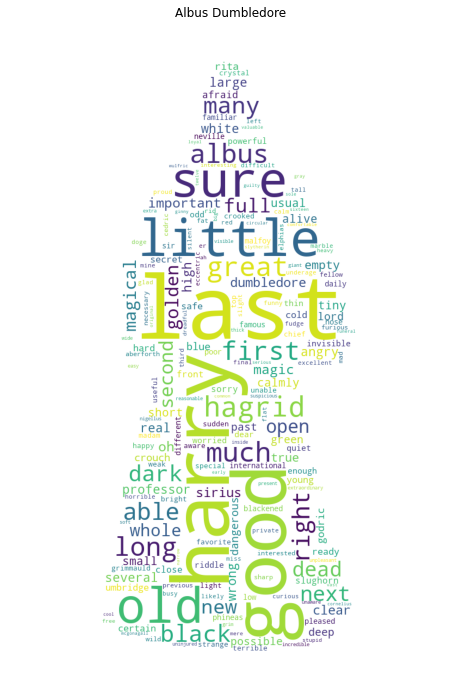

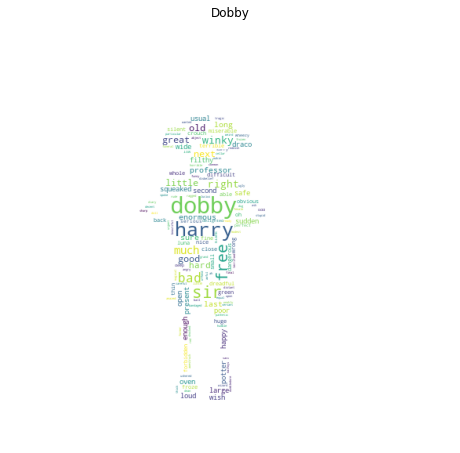

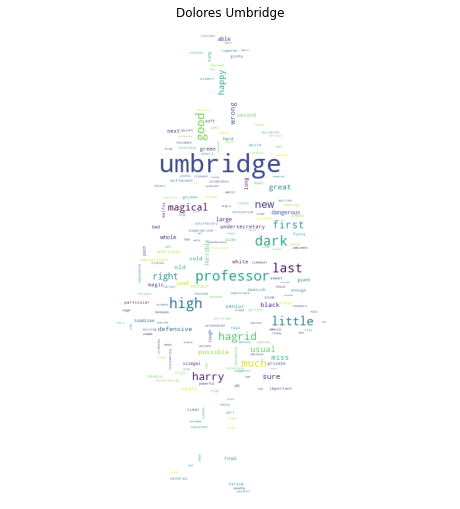

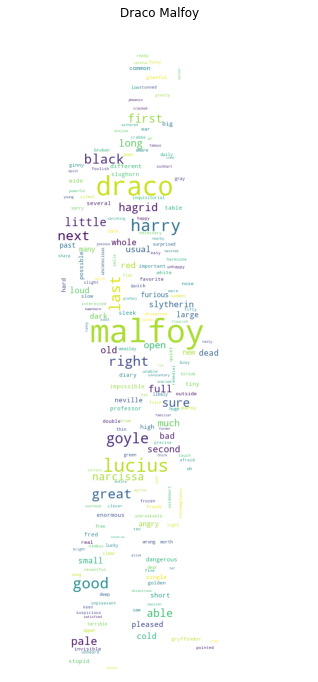

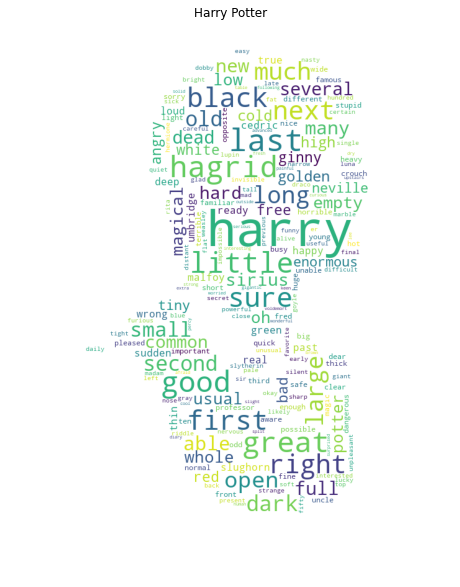

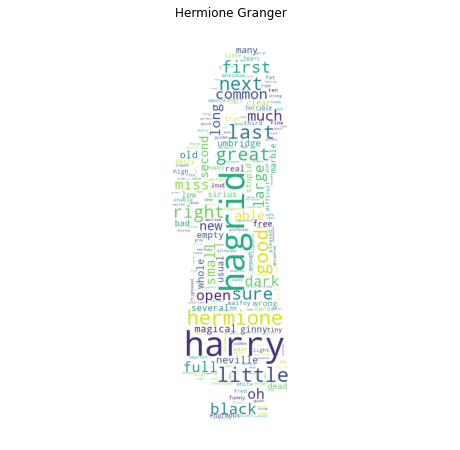

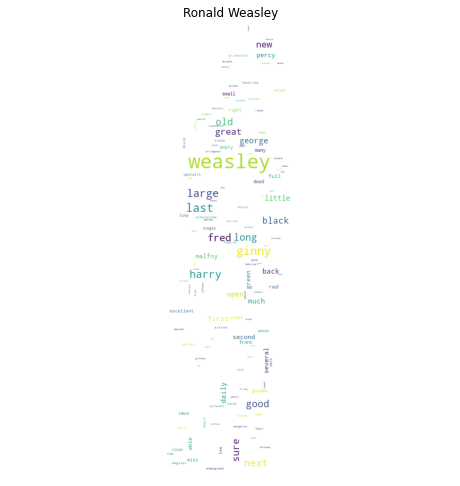

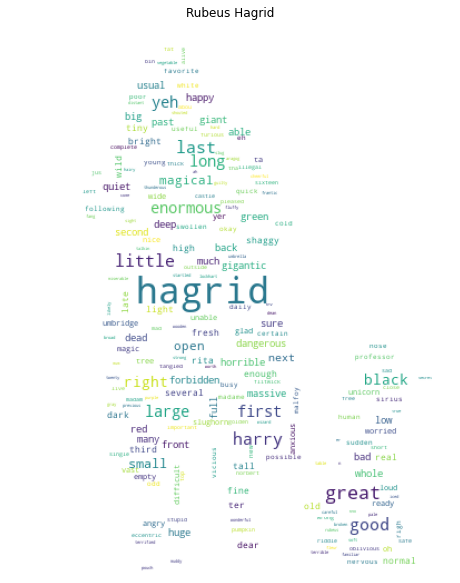

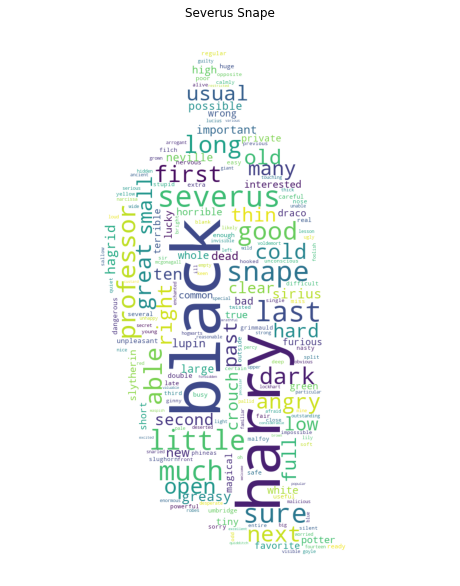

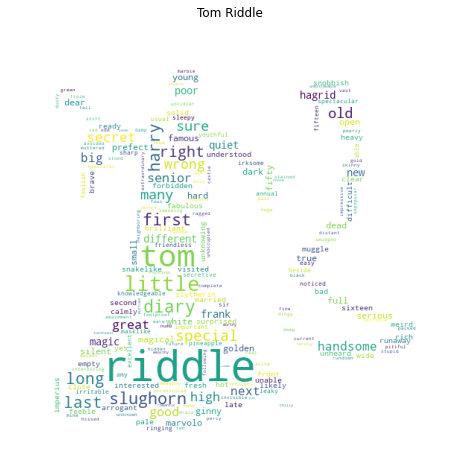

In [191]:
for name in namelist:
    generate_wordcloud(name)

<a id='sentiment_analysis'></a>
### 3.2.2 Sentiment analysis
In this section, we will implement sentiment analysis on both characters and House. We try to find out which characters are happiest or the saddest. We are also curious whether the author has different feelings when describing different houses.

<a id='sentiment_character'></a>
#### 3.2.2.1 Sentiment analysis on characters

In [194]:
df_books = pd.read_csv('CharactersInBook.csv')
booknames = df_books['Name'].values.tolist() #Get the characters name list
bookhouses = df_books['houses'].values.tolist() #Get the houses list
bookhouses = list(set(bookhouses)) #Get the unique house name 

wikinames = df['Name'].values.tolist() #Get the characters name list
wikihouses = df['houses'].values.tolist() #Get the houses list
wikihouses = list(set(wikihouses)) #Get the unique house name 

In [195]:
df_vader = pd.read_csv('./vader_lexicon.txt',sep='\t',header=None)
df_vader.columns = ["TOKEN", "MEAN-SENTIMENT-RATING", "STANDARD DEVIATION", "RAW-HUMAN-SENTIMENT-RATINGS"]
analyzer = SentimentIntensityAnalyzer()

In [196]:
def sentiment_score(text):
    polarity = [analyzer.polarity_scores(s)['compound'] for s in text]
    polarity_mean = np.mean(polarity)
    return polarity_mean

In [197]:
with open('./booktext.json','r',encoding='utf-8') as f:
    booktext = json.load(f)
charactersbook = list(booktext.keys())
textbook = list(booktext.values())

sentiment_book = {}
for i,name in enumerate(charactersbook):
    polarity = [analyzer.polarity_scores(s)['compound'] for s in textbook[i]]
    polarity_mean = np.mean(polarity)
    sentiment_book[name] = polarity_mean

In [198]:
with open('./wikitext.json','r',encoding='utf-8') as f:
    wikitext = json.load(f)
characterswiki = list(wikitext.keys())
textwiki = list(wikitext.values())

sentiment_wiki = {}
for i,name in enumerate(characterswiki):
    polarity = [analyzer.polarity_scores(s)['compound'] for s in textwiki[i]]
    polarity_mean = np.mean(polarity)
    sentiment_wiki[name] = polarity_mean

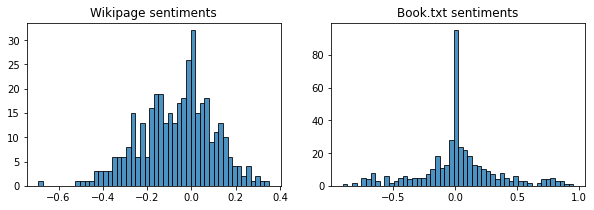

In [199]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(sentiment_wiki.values(), 50, alpha=0.8, edgecolor='black')
plt.title('Wikipage sentiments')
plt.subplot(1, 2, 2)
plt.hist(sentiment_book.values(), 50, alpha=0.8, edgecolor='black')
_ = plt.title('Book.txt sentiments')
plt.savefig('./Figures/Sentiment.png',dpi = 300)

>From the sentiment distribution, we could find out that the emotional of most characters is very neutral. In the book, some characters are very happy and some characters are vey sad, itis very evenly distributed. And in the wiki page, it's looks like there are more characters and sad and less characters are happy. It may because the wikipage is written by the fans, not only one person, and different person will have different feelings to characters, so the emotion distribution is a little uneven.    
>
>Next let's see the top 10 happiness characters and sadness characters ivdividually. 

In [200]:
# transfer target dictionary to dataframe format
def dict_df(dictionary):
    character_name = []
    sentiment = []

    for k, v in dictionary.items():
        character_name.append(k)
        sentiment.append(v)

    df = pd.DataFrame()
    df['Name'] = character_name
    df['Sentiment'] = sentiment

    return df

In [201]:
df_sentiment_book = dict_df(sentiment_book)

In [202]:
###Show top 10 happiness characters in book
df_sentiment_book.sort_values(by = 'Sentiment',ascending=False).head(10)

Name  Sentiment
216     Barnabus Finkley     0.9545
394        Eldred Worple     0.9153
297             Mortlake     0.8780
105  Cassandra Vablatsky     0.8611
395        Bowman Wright     0.8479
295           Montgomery     0.8299
71    Montgomery sisters     0.8299
361             Tenebrus     0.8126
397    Ladislaw Zamojski     0.7992
342           Barry Ryan     0.7992

In [203]:
###Show top 10 sadness characters in book
df_sentiment_book.sort_values(by = 'Sentiment',ascending=True).head(10)

Name  Sentiment
269   Lachlan the Lanky  -0.906200
187   Barnabas Deverill  -0.812600
348    Stanley Shunpike  -0.800200
410              Savage  -0.747600
409           Proudfoot  -0.747600
153         Edgar Bones  -0.743000
183    Caradoc Dearborn  -0.743000
232              Gibbon  -0.742867
334   Tom Riddle Senior  -0.718400
378  Vindictus Viridian  -0.712800

In [204]:
df_sentiment_wiki = dict_df(sentiment_wiki)

In [205]:
###Show top 10 happiness characters in wikipage
df_sentiment_wiki.sort_values(by = 'Sentiment',ascending=False).head(10)

Name  Sentiment
155                                      Alphard Black   0.351079
311                                      Myron Wagtail   0.323305
101                             Prime Minister's niece   0.294467
24                                   Apolline Delacour   0.293944
337  1996 Gryffindor Quidditch Keeper trials specta...   0.281220
45                              Gregory Goyle's mother   0.262625
308                              Violet-cloaked wizard   0.260086
336                                       Zoo director   0.257233
17                                 Cho Chang's friends   0.252445
129                           St Mungo's Welcome Witch   0.232525

In [206]:
###Show top 10 sadness characters in wikipage
df_sentiment_wiki.sort_values(by = 'Sentiment',ascending=True).head(10)

Name  Sentiment
361                          Hedwig's killer  -0.690618
9                          Edgar Bones' wife  -0.507467
12                   Lavender Brown's mother  -0.494067
152                           Benjamin Hater  -0.481900
140             Arkie Alderton's alleged son  -0.441860
164                  Lavender Brown's father  -0.433867
234               Landlord of The Hanged Man  -0.430880
365  James and Lily Potter's Muggle betrayer  -0.430138
127                   Myrtle Warren's mother  -0.416467
76              Montgomery children's mother  -0.410625

>From the above table, we could find out the result in book is different with in wikipage. As we already mentioned in the distribution, that the emotion in book is stronger than emotion in wikipage.  
>
>For the characters who are most happiness, we could find out they are all obsessed with their hobbies and very success. Take the most happiest character in the book **Barnabus Finkley** as example, Barnabus Finkley was a wizard and the Barnabus Finkley Prize for Exceptional Spell-Casting was named in his honour. Thus, he was presumably an exceptional spell-caster. A successful career is indeed a very happy thing. 
>
>For the characters who are most sadness, they all have their own sad story. Take the **Tom Riddle Senior** as example,he is **The Dark Lord's father**, and finally murdered by his son,Tom Marvolo Riddle.

<a id='sentiment_house'></a>
#### 3.2.2.1 Sentiment analysis on houses

In [207]:
with open('./housebook.json','r',encoding='utf-8') as f:
    housebook = json.load(f)
charactershouse = list(housebook.keys())
texthousebook = list(housebook.values())

sentiment_housebook = {}
for i,name in enumerate(charactershouse):
    polarity = [analyzer.polarity_scores(s)['compound'] for s in texthousebook[i]]
    polarity_mean = np.mean(polarity)
    sentiment_housebook[name] = polarity_mean

In [208]:
df_sentiment_housebook = dict_df(sentiment_housebook)
df_sentiment_housebook

Name  Sentiment
0  Gryffindor  -0.018993
1     unknown  -0.094479
2   Ravenclaw  -0.017877
3   Slytherin  -0.100293
4  Hufflepuff   0.026294

In [209]:
with open('./housewiki.json','r',encoding='utf-8') as f:
    housewiki = json.load(f)
characterswiki = list(housewiki.keys())
texthousewiki = list(housewiki.values())

sentiment_housewiki = {}
for i,name in enumerate(characterswiki):
    polarity = [analyzer.polarity_scores(s)['compound'] for s in texthousewiki[i]]
    polarity_mean = np.mean(polarity)
    sentiment_housewiki[name] = polarity_mean

In [210]:
df_sentiment_housewiki = dict_df(sentiment_housewiki)
df_sentiment_housewiki

Name  Sentiment
0  Gryffindor  -0.018993
1     unknown  -0.094501
2   Ravenclaw  -0.017877
3   Slytherin  -0.100293
4  Hufflepuff   0.026294

>From the above table, we could find out that both house sentiment in book and in wikipage don't have obvious difference. Eventhough some of them sentiment score are positive, some are negative, but the actual difference is very small, which is far away from our expection. We thought Gryffindor may be the happest house and Slytherin may be saddest House. However, the result is not.    
>
>From all of these four house, Hufflepuff is the happies house. Hufflepuff was the most inclusive among the four houses, valuing hard work, dedication, patience, loyalty, and fair play rather than a particular aptitude in its members.Perhaps it is precisely because of these characteristics that all students feel accepted in Hufflepuff, so they all live happy.   
>
>Slytherin is the saddest house. Maybe it's because in the Harry Potter story, many students of Slytherin are villains, such as Lord Voldemort, Malfoy family etc.

<a id='community_detection'></a>
## 3.3 Community Detection

As mentioned before, when new students join in Howgarts, Sorting Hat will assign them to four different Houses: Gryffindor, Hufflepuff, Ravenclaw and Slytherin. The Sorting Hat works based on the each student unique characteristic.   

In our former work, we generate the Harry Potter network based on WiKi links, We are wondering  what if we use community detection to extract the communities form Harry Potter network? Can we get similar result as sorting Hat?  

The way we used to detect community is Louvain Algorithm.The Louvain algorithm is a method to extract communities from large networks. The Louvain algorithm consists of two steps that are repeated iteratively.  
* **Step 1**: First, each node in the network is assigned to its own community. For each node i we evaluate the gain in modularity if we place node i in the community of one of its neighbors j. We then move node i in the community for which the modularity gain is the largest, but only if this gain is positive. If no positive gain is found, i stays in its original community. This process is applied to all nodes until no further improvement can be achieved, completing Step 1.    
* **Step 2**: We construct a new network whose nodes are the communities identified during Step 1. The weight of the link between two nodes is the sum of the weight of the links between the nodes in the corresponding communities. Links between nodes of the same community lead to weighted self-loops.  
* Once Step 2 is completed, we repeat Steps 1 - 2, calling their combination a pass. The number of communities decreases with each pass. The passes are repeated until there are no more changes and maximum modularity is attained.


In [11]:
part = community.best_partition(GCC)   #Find the communities in the Harry Potter network
modularity_value = community.modularity(part, GCC)        #Calculate the value of modularity

part_df = pd.DataFrame.from_dict(part,orient='index')
part_df.columns=['Community']
part_dict = part_df.Community.value_counts().to_dict()  #Get the community size and store them into dictionary
part_dict_sort = sorted(part_dict.items(),key=lambda item:item[0]) #Sort by community size

We find 10 communities in total
The value of modularity with the partition created by the algorithm is 0.29


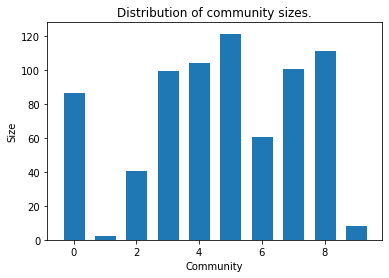

In [20]:
print('We find %d communities in total' % len(part_dict_sort))  
print('The value of modularity with the partition created by the algorithm is %.2f' % modularity_value) \
#Plot the distribution of community sizes.
communitynum = []
communityhist = []
for i in range(len(part_dict_sort)):
    communitynum.append(part_dict_sort[i][0])
    communityhist.append(part_dict_sort[i][1])

bar_hist = plt.bar(communitynum, communityhist, width=0.7, edgecolor='white')
plt.xlabel('Community'); plt.ylabel('Size'); _ = plt.title('Distribution of community sizes.')
plt.savefig('./Figures/CommunityDistrubtion.png',dpi = 300)

>After execute community detection, we find 9 communitites in total, and the modularity with the partition created by the algorithm is 0.29.   
>
>In order to compare the network consisted by community, first, we find the four largest communities, Then for the node in these communities, we assigned them different color. For nodes don't belong to these communities, we assigned them grey.   

In [21]:
community4 = list(part_dict.keys())[:4] #Get the 4 largest communities
print("the 4 largest community is:",community4)

the 4 largest community is: [5, 8, 4, 7]


In [22]:
#Find the characters which belong to the 4 largest communities
c4name = []
for comname in community4:
    c4name.append(part_df[part_df.Community==comname].index.tolist())

In [23]:
colors = ['#A9203E','#217655','#00345B','#E9B636','#808080'] # 4 main community + other
color_map = []

for name in GCC.nodes():
    checkname = False
    for i in range(4):
        if name in c4name[i]:
            color_map.append(colors[i])
            checkname = True
    if checkname == False:
       color_map.append(colors[-1] ) 
# setting the size of each node     
size = list(dict(GCC.degree()).values())
new_size = [i *10 for i in size]

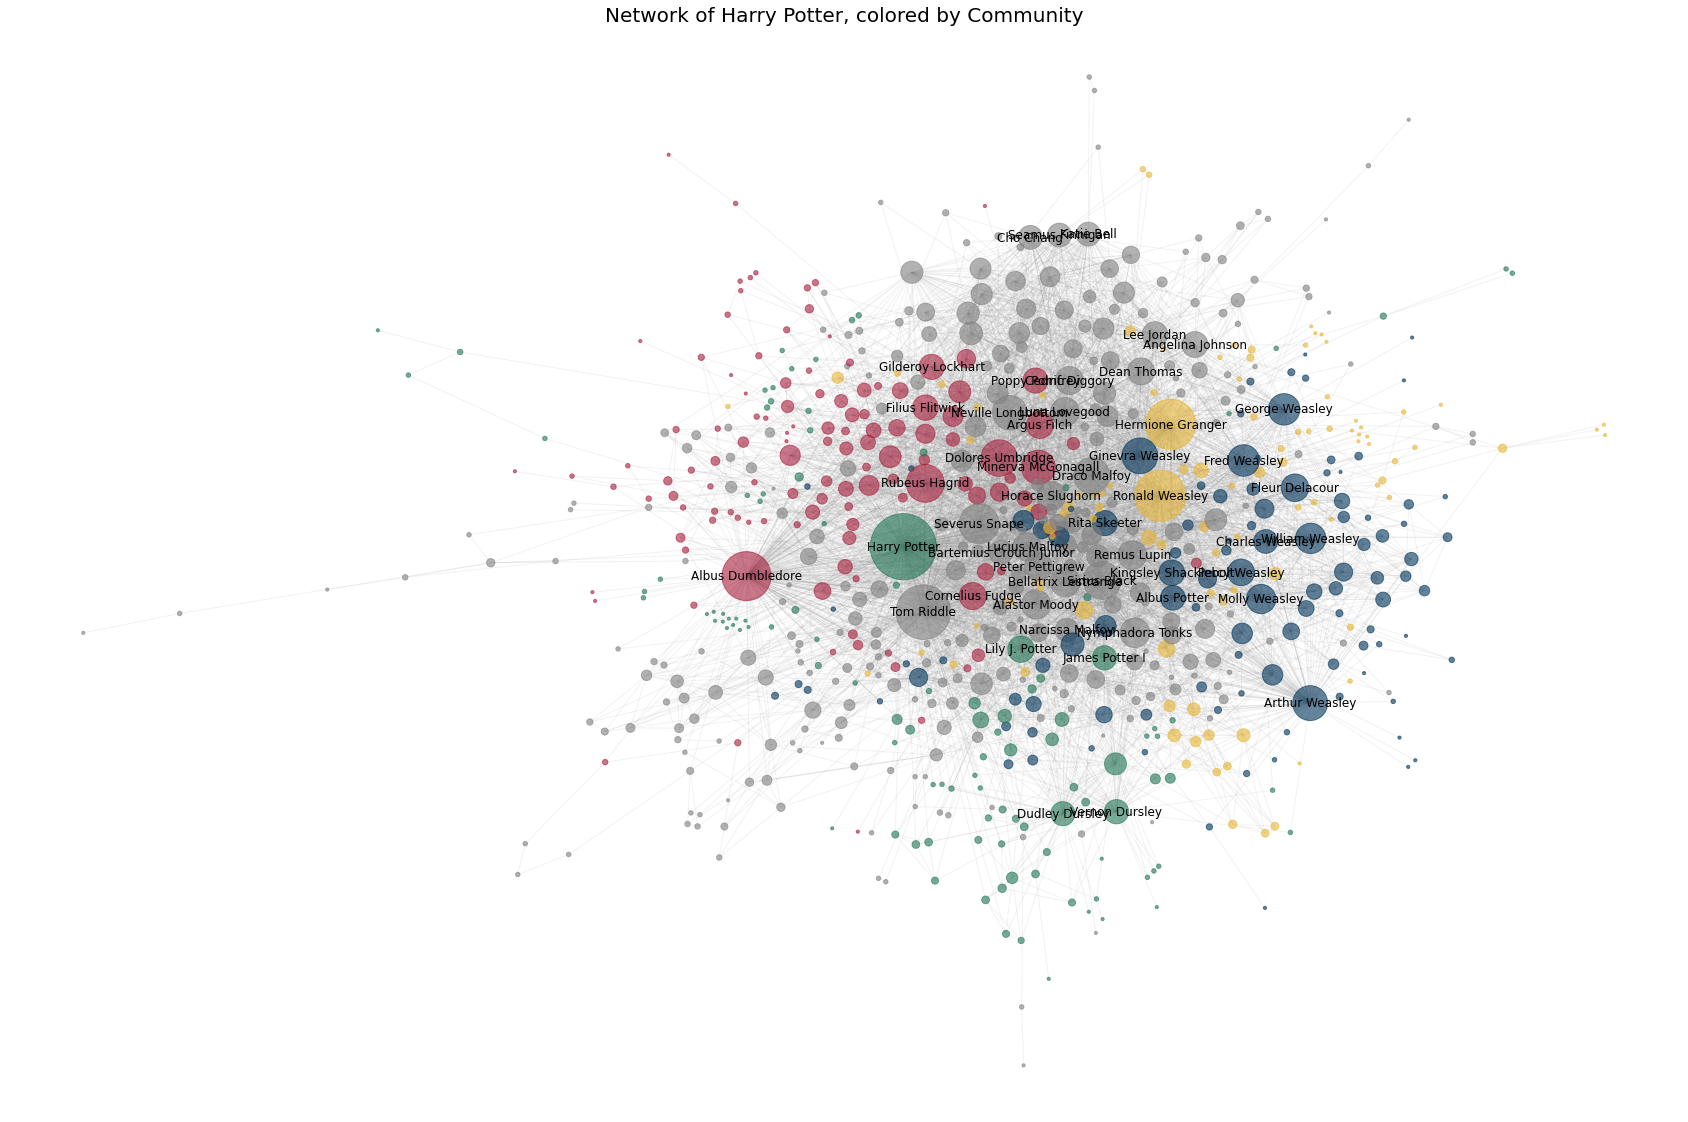

In [26]:
plt.figure(figsize=(30,20))
nx.draw_networkx_nodes(GCC, positions, node_size=new_size, node_color=color_map, alpha=0.6)
nx.draw_networkx_edges(GCC, positions, edge_color="#808080", alpha=0.1)
nx.draw_networkx_labels(GCC,positions,labels,font_size=12,font_color='k')
plt.axis('off')
plt.title('Network of Harry Potter, colored by Community',fontdict = {'fontsize' : 20})
plt.savefig('./Figures/NetworkColorCommunity.png',dpi = 600)
plt.show()

>From the figure, it is clear to see that the result is different with the original House labels.
>* The blue community, it seems to be Weasley family, we can see Arthur Wealey, Molly Weasley, William Weasley, Ferd Weasley and George Weasley, which belong to green community.
>
>* The yellow community, it may be the Harry Potter's close friends. We can see Ronald Weasley and Hermione Granger both belongs to this community.
>
>* The green community consist of Potter family, we can see Harry Potter, Lily Potter, James Potter and Dursley family.
>
>* It is hard for us to find what's the connection between the characters in red community. They from different houses, with different gender. Most of them are teachers, so maybe it's consist of teachers.
>
>* It is surprised that Tom Riddle doesn't belongs to top 4 biggest community.

<a id='discussion'></a>
# 4 Discussions

* **What went well?**:

> 1. We think our 2-minute movie is successful, just like we go through 8 Harry Potter movies again!
> 2. It's nice to confirm Friendship Paradox and Six Degrees of Separation in our network.
> 3. After tunning our algorithm(from TF-IDF to TF-TR), the key words are much more reasonable.

* **What is still missing and needs to be improved?**:

> 1. Although our network graphs are pretty, we actually didn't dig out much valuable imformation from them. Maybe we should filter out some edges.
> 2. We filtered all the characters' names in text analysis, which may result in losing useful information, because there are descriptive languages in names.

<a id='contribution'></a>
# 5 Contributions

* **Hui Wang**:
    1. Data collection
    2. Data prcess
    3. Text analysis and wordcloud generation
    4. Sentiment analysis
    5. Community detection


* **Tianyi Ma**:
    1. Building website
    2. Editing video
    3. Post-processing of graphs


* **Yun Ma**:
    1. Data prcessing(extract characters in books)
    2. Network building and visualization
    3. Friendship Paradox and Six Degrees of Separation
    3. Final explainer notebook